## Visualizing Filters of a Convolutional Neural Network

In this exercise, we will use a Convolutional Neural Network - the popular VGG16 model, and we will visualize various filters from different layers of the CNN. We will do this by using gradient ascent to visualize images that maximally activate specific filters from different layers of the model.

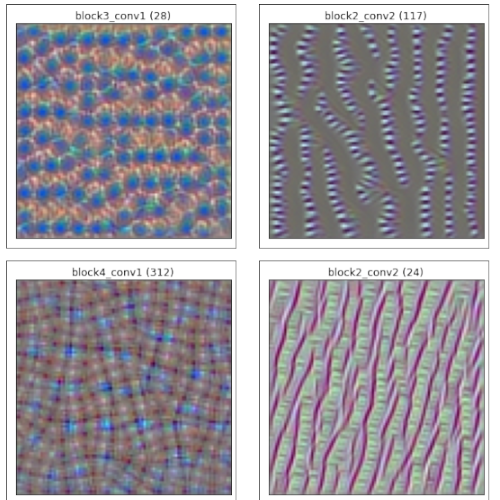

In a pre-trained model, the filters have learned to get activated for specific input features. Let's visualize those input features.

## Task 2: Downloading the Model

In [1]:
import tensorflow as tf
import random
import matplotlib.pyplot as plt

print('Tensorflow version', tf.__version__)

Tensorflow version 2.4.1


In [2]:
model = tf.keras.applications.vgg16.VGG16(
    include_top=False, # final fully-connected layer is not imported
    weights='imagenet',
    input_shape=(96, 96, 3),
)
model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
______________________________________________________________

In block1 and block2, simple features are learned. Block3 learns more sophisticated features. Block4 and block5 learn complicated features.

In [3]:
model = tf.keras.applications.mobilenet.MobileNet(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3)
)
model.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________

## Task 3: Get Layer Output

In [4]:
def get_submodel(layer_name):
  return tf.keras.models.Model(
      model.input,
      model.get_layer(layer_name).output
  )

get_submodel('conv_pw_10').summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

## Task 4: Image Visualization

In [11]:
def create_image():
  tf.random.set_seed(1234)
  return tf.random.uniform((224, 224, 3), minval=-0.5, maxval=0.5)

def plot_image(image, title='random'):
  image = image - tf.math.reduce_min(image) # make sure that all values are positive
  image = image / tf.math.reduce_max(image)
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])
  plt.title(title)
  plt.show()



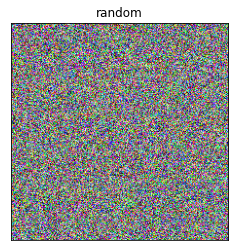

In [12]:
image = create_image()
plot_image(image)

## Task 5: Training Loop

In [13]:
def visualize_filter(layer_name, f_index=None, iters=50):
  submodel = get_submodel(layer_name)
  num_filters = submodel.output.shape[-1] # get number of filters that submodel has in output

  if f_index is None:
    f_index = random.randint(0, num_filters - 1) # minus 1 because value is inclusive
  assert num_filters > f_index, 'f_index is out of bounds'

  image = create_image()

  # keep track of the loss
  verbose_step = int(iters / 10)

  # do gradient ascent: try to maximize
  for i in range(0, iters):
    with tf.GradientTape() as tape:
      tape.watch(image)
      out = submodel(tf.expand_dims(image, axis=0))[:,:,:,f_index]
      loss = tf.math.reduce_mean(out)

    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += grads * 10  # summarize because we're doing gradient ascent; large learning rate to speed up

    if (i + 1) % verbose_step == 0:
      print(f'Iteration: {i+1}, Loss: {loss.numpy(): .4f}')

  plot_image(image, f'{layer_name}, {f_index}')

In [66]:
num_filters = 32
columns=8
(int(num_filters/columns)*3, columns*3)

(12, 24)

In [73]:
def visualize_all_filters(layer_name, iters=50):
  verbose = False

  submodel = get_submodel(layer_name)
  num_filters = submodel.output.shape[-1] # get number of filters that submodel has in output
  print(f'Number of Filters: {num_filters}')
  image = create_image()

  # keep track of the loss
  verbose_step = int(iters / 10)

  columns = 8
  plt.figure(figsize=(int(num_filters/columns)*6, columns*3))

  for f_index in range(num_filters):
    # do gradient ascent: try to maximize
    for i in range(0, iters):
      with tf.GradientTape() as tape:
        tape.watch(image)
        out = submodel(tf.expand_dims(image, axis=0))[:,:,:,f_index]
        loss = tf.math.reduce_mean(out)

      grads = tape.gradient(loss, image)
      grads = tf.math.l2_normalize(grads)
      image += grads * 10  # summarize because we're doing gradient ascent; large learning rate to speed up

      if verbose:
        if (i + 1) % verbose_step == 0:
          print(f'Iteration: {i+1}, Loss: {loss.numpy(): .4f}')

    print(f'Filter {f_index}, Loss: {loss.numpy(): .4f}')

    image = image - tf.math.reduce_min(image) # make sure that all values are positive
    image = image / tf.math.reduce_max(image)

    ax = plt.subplot(int(num_filters / columns + 1), columns, f_index + 1)
    ax.set_title(f'Filter {f_index}')
    plt.suptitle(layer_name, fontsize=20, fontweight='bold')
    plt.axis('off')
    plt.imshow(image)
  
  plt.show()



## Task 6: Final Results

In [74]:
print([layer.name for layer in model.layers if 'conv' in layer.name])

['conv1', 'conv1_bn', 'conv1_relu', 'conv_dw_1', 'conv_dw_1_bn', 'conv_dw_1_relu', 'conv_pw_1', 'conv_pw_1_bn', 'conv_pw_1_relu', 'conv_pad_2', 'conv_dw_2', 'conv_dw_2_bn', 'conv_dw_2_relu', 'conv_pw_2', 'conv_pw_2_bn', 'conv_pw_2_relu', 'conv_dw_3', 'conv_dw_3_bn', 'conv_dw_3_relu', 'conv_pw_3', 'conv_pw_3_bn', 'conv_pw_3_relu', 'conv_pad_4', 'conv_dw_4', 'conv_dw_4_bn', 'conv_dw_4_relu', 'conv_pw_4', 'conv_pw_4_bn', 'conv_pw_4_relu', 'conv_dw_5', 'conv_dw_5_bn', 'conv_dw_5_relu', 'conv_pw_5', 'conv_pw_5_bn', 'conv_pw_5_relu', 'conv_pad_6', 'conv_dw_6', 'conv_dw_6_bn', 'conv_dw_6_relu', 'conv_pw_6', 'conv_pw_6_bn', 'conv_pw_6_relu', 'conv_dw_7', 'conv_dw_7_bn', 'conv_dw_7_relu', 'conv_pw_7', 'conv_pw_7_bn', 'conv_pw_7_relu', 'conv_dw_8', 'conv_dw_8_bn', 'conv_dw_8_relu', 'conv_pw_8', 'conv_pw_8_bn', 'conv_pw_8_relu', 'conv_dw_9', 'conv_dw_9_bn', 'conv_dw_9_relu', 'conv_pw_9', 'conv_pw_9_bn', 'conv_pw_9_relu', 'conv_dw_10', 'conv_dw_10_bn', 'conv_dw_10_relu', 'conv_pw_10', 'conv_pw_10_

Number of Filters: 32
Filter 0, Loss: -0.0000
Filter 1, Loss:  32.5242
Filter 2, Loss:  17.2084
Filter 3, Loss:  0.0000
Filter 4, Loss:  0.0000
Filter 5, Loss:  33.2581
Filter 6, Loss:  14.3426
Filter 7, Loss:  19.2092
Filter 8, Loss:  0.0000
Filter 9, Loss:  38.1255
Filter 10, Loss:  44.4651
Filter 11, Loss:  0.0000
Filter 12, Loss:  17.1091
Filter 13, Loss:  22.3626
Filter 14, Loss:  14.7544
Filter 15, Loss:  0.0072
Filter 16, Loss: -0.0000
Filter 17, Loss:  33.5746
Filter 18, Loss:  15.5543
Filter 19, Loss:  16.2340
Filter 20, Loss:  0.0000
Filter 21, Loss:  0.0000
Filter 22, Loss:  34.5919
Filter 23, Loss:  23.1732
Filter 24, Loss:  0.8582
Filter 25, Loss:  16.2904
Filter 26, Loss:  41.8837
Filter 27, Loss:  27.1197
Filter 28, Loss:  11.5058
Filter 29, Loss:  37.1313
Filter 30, Loss:  13.7708
Filter 31, Loss:  0.3380


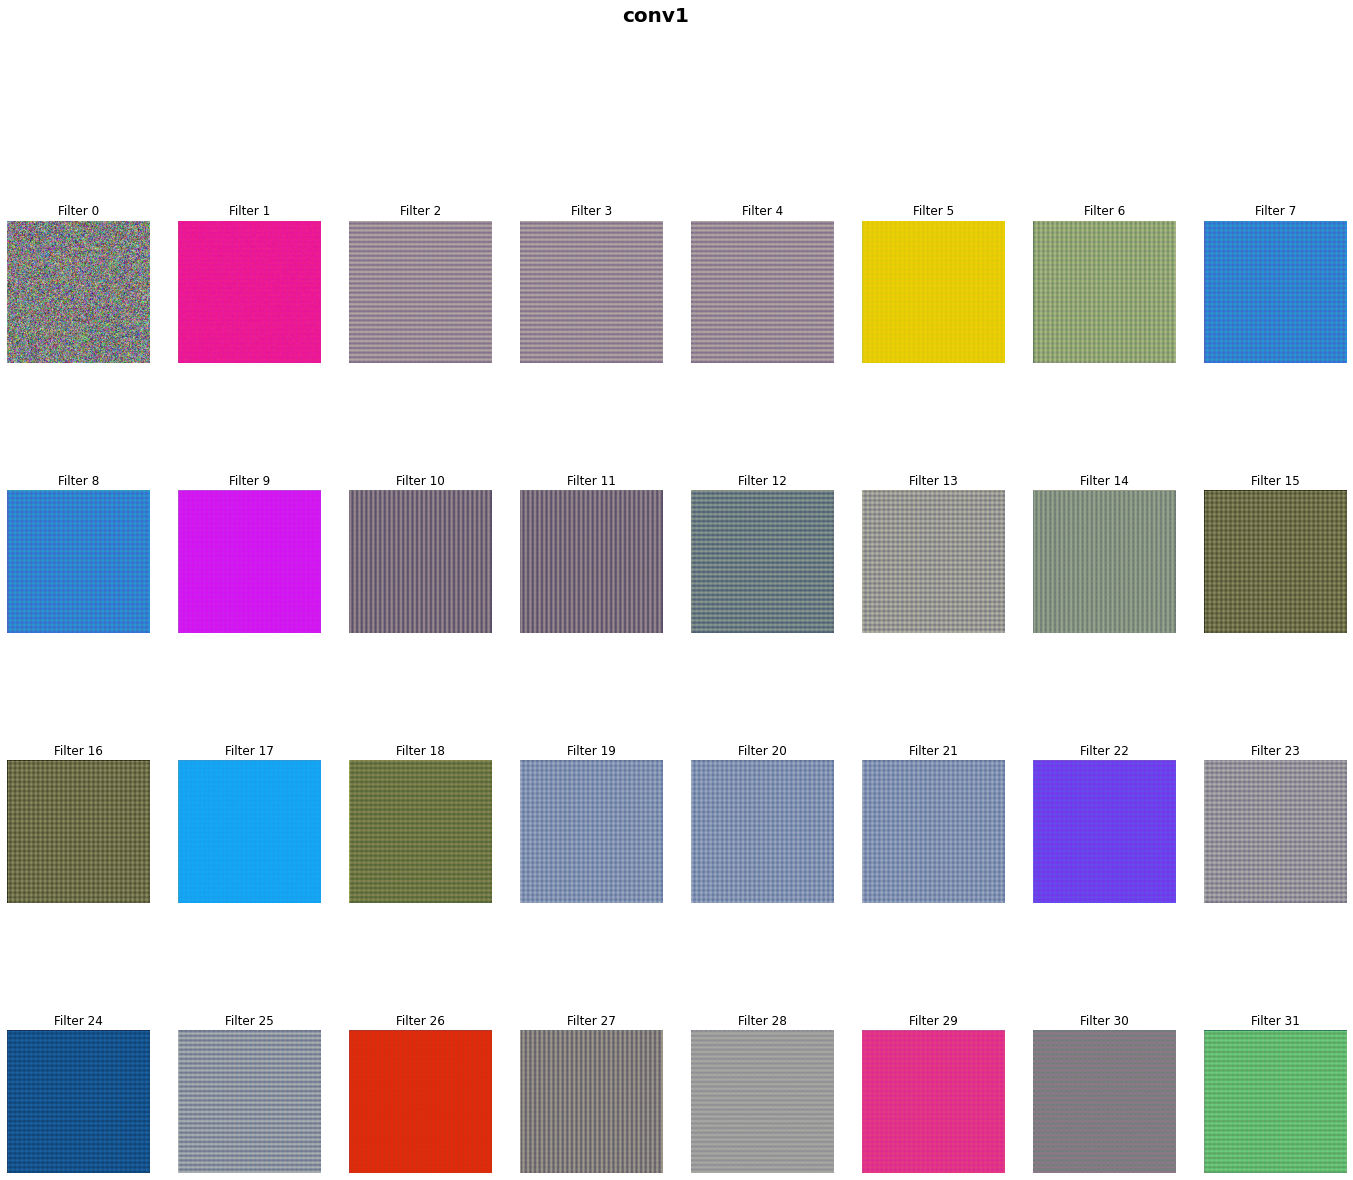

In [75]:
layer_name = 'conv1' #@param ['conv1', 'conv1_bn', 'conv1_relu', 'conv_dw_1', 'conv_dw_1_bn', 'conv_dw_1_relu', 'conv_pw_1', 'conv_pw_1_bn', 'conv_pw_1_relu', 'conv_pad_2', 'conv_dw_2', 'conv_dw_2_bn', 'conv_dw_2_relu', 'conv_pw_2', 'conv_pw_2_bn', 'conv_pw_2_relu', 'conv_dw_3', 'conv_dw_3_bn', 'conv_dw_3_relu', 'conv_pw_3', 'conv_pw_3_bn', 'conv_pw_3_relu', 'conv_pad_4', 'conv_dw_4', 'conv_dw_4_bn', 'conv_dw_4_relu', 'conv_pw_4', 'conv_pw_4_bn', 'conv_pw_4_relu', 'conv_dw_5', 'conv_dw_5_bn', 'conv_dw_5_relu', 'conv_pw_5', 'conv_pw_5_bn', 'conv_pw_5_relu', 'conv_pad_6', 'conv_dw_6', 'conv_dw_6_bn', 'conv_dw_6_relu', 'conv_pw_6', 'conv_pw_6_bn', 'conv_pw_6_relu', 'conv_dw_7', 'conv_dw_7_bn', 'conv_dw_7_relu', 'conv_pw_7', 'conv_pw_7_bn', 'conv_pw_7_relu', 'conv_dw_8', 'conv_dw_8_bn', 'conv_dw_8_relu', 'conv_pw_8', 'conv_pw_8_bn', 'conv_pw_8_relu', 'conv_dw_9', 'conv_dw_9_bn', 'conv_dw_9_relu', 'conv_pw_9', 'conv_pw_9_bn', 'conv_pw_9_relu', 'conv_dw_10', 'conv_dw_10_bn', 'conv_dw_10_relu', 'conv_pw_10', 'conv_pw_10_bn', 'conv_pw_10_relu', 'conv_dw_11', 'conv_dw_11_bn', 'conv_dw_11_relu', 'conv_pw_11', 'conv_pw_11_bn', 'conv_pw_11_relu', 'conv_pad_12', 'conv_dw_12', 'conv_dw_12_bn', 'conv_dw_12_relu', 'conv_pw_12', 'conv_pw_12_bn', 'conv_pw_12_relu', 'conv_dw_13', 'conv_dw_13_bn', 'conv_dw_13_relu', 'conv_pw_13', 'conv_pw_13_bn', 'conv_pw_13_relu']

visualize_all_filters(layer_name, iters=200)

Number of Filters: 32
Filter 0, Loss:  0.0000
Filter 1, Loss:  6.0000
Filter 2, Loss:  6.0000
Filter 3, Loss:  0.0000
Filter 4, Loss:  0.0000
Filter 5, Loss:  6.0000
Filter 6, Loss:  6.0000
Filter 7, Loss:  5.9998
Filter 8, Loss:  0.0000
Filter 9, Loss:  6.0000
Filter 10, Loss:  6.0000
Filter 11, Loss:  0.1072
Filter 12, Loss:  6.0000
Filter 13, Loss:  6.0000
Filter 14, Loss:  6.0000
Filter 15, Loss:  0.2323
Filter 16, Loss:  0.0000
Filter 17, Loss:  6.0000
Filter 18, Loss:  6.0000
Filter 19, Loss:  6.0000
Filter 20, Loss:  0.0000
Filter 21, Loss:  0.0000
Filter 22, Loss:  6.0000
Filter 23, Loss:  6.0000
Filter 24, Loss:  6.0000
Filter 25, Loss:  6.0000
Filter 26, Loss:  6.0000
Filter 27, Loss:  6.0000
Filter 28, Loss:  5.9794
Filter 29, Loss:  6.0000
Filter 30, Loss:  6.0000
Filter 31, Loss:  6.0000


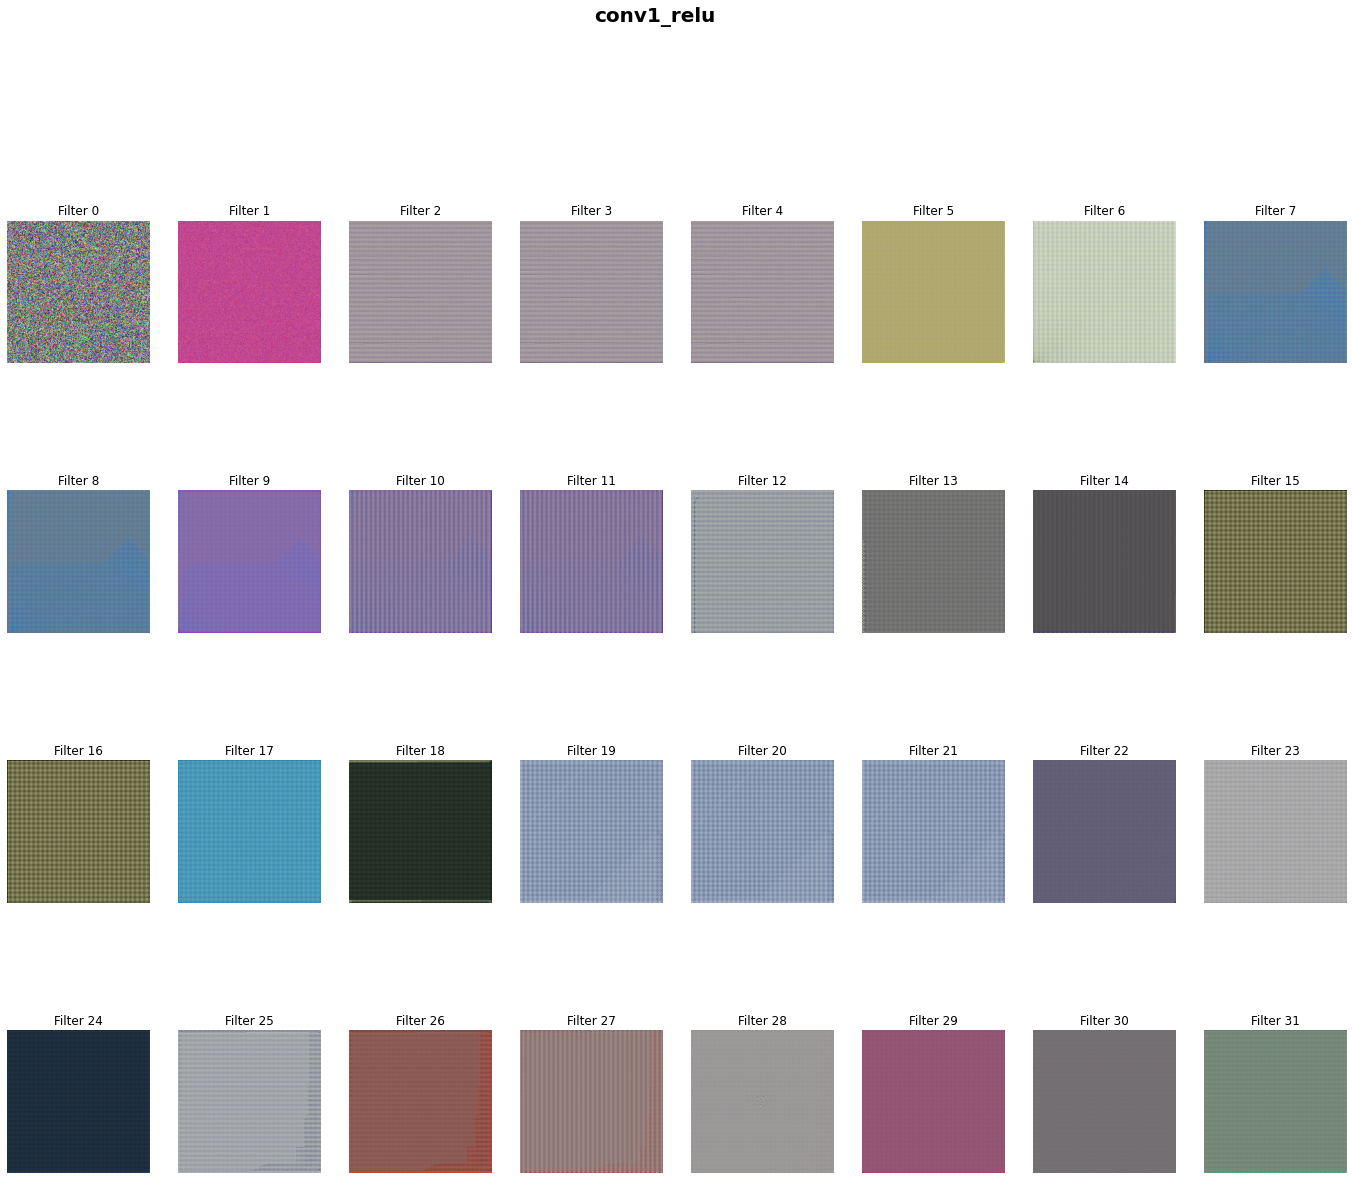

In [76]:
layer_name = 'conv1_relu' #@param ['conv1', 'conv1_bn', 'conv1_relu', 'conv_dw_1', 'conv_dw_1_bn', 'conv_dw_1_relu', 'conv_pw_1', 'conv_pw_1_bn', 'conv_pw_1_relu', 'conv_pad_2', 'conv_dw_2', 'conv_dw_2_bn', 'conv_dw_2_relu', 'conv_pw_2', 'conv_pw_2_bn', 'conv_pw_2_relu', 'conv_dw_3', 'conv_dw_3_bn', 'conv_dw_3_relu', 'conv_pw_3', 'conv_pw_3_bn', 'conv_pw_3_relu', 'conv_pad_4', 'conv_dw_4', 'conv_dw_4_bn', 'conv_dw_4_relu', 'conv_pw_4', 'conv_pw_4_bn', 'conv_pw_4_relu', 'conv_dw_5', 'conv_dw_5_bn', 'conv_dw_5_relu', 'conv_pw_5', 'conv_pw_5_bn', 'conv_pw_5_relu', 'conv_pad_6', 'conv_dw_6', 'conv_dw_6_bn', 'conv_dw_6_relu', 'conv_pw_6', 'conv_pw_6_bn', 'conv_pw_6_relu', 'conv_dw_7', 'conv_dw_7_bn', 'conv_dw_7_relu', 'conv_pw_7', 'conv_pw_7_bn', 'conv_pw_7_relu', 'conv_dw_8', 'conv_dw_8_bn', 'conv_dw_8_relu', 'conv_pw_8', 'conv_pw_8_bn', 'conv_pw_8_relu', 'conv_dw_9', 'conv_dw_9_bn', 'conv_dw_9_relu', 'conv_pw_9', 'conv_pw_9_bn', 'conv_pw_9_relu', 'conv_dw_10', 'conv_dw_10_bn', 'conv_dw_10_relu', 'conv_pw_10', 'conv_pw_10_bn', 'conv_pw_10_relu', 'conv_dw_11', 'conv_dw_11_bn', 'conv_dw_11_relu', 'conv_pw_11', 'conv_pw_11_bn', 'conv_pw_11_relu', 'conv_pad_12', 'conv_dw_12', 'conv_dw_12_bn', 'conv_dw_12_relu', 'conv_pw_12', 'conv_pw_12_bn', 'conv_pw_12_relu', 'conv_dw_13', 'conv_dw_13_bn', 'conv_dw_13_relu', 'conv_pw_13', 'conv_pw_13_bn', 'conv_pw_13_relu']

visualize_all_filters(layer_name, iters=200)

Number of Filters: 64
Filter 0, Loss:  5.2398
Filter 1, Loss:  6.4265
Filter 2, Loss:  8.1315
Filter 3, Loss:  8.4383
Filter 4, Loss:  4.5477
Filter 5, Loss:  5.3057
Filter 6, Loss:  4.6340
Filter 7, Loss:  0.5425
Filter 8, Loss:  4.0662
Filter 9, Loss:  6.0209
Filter 10, Loss:  0.1781
Filter 11, Loss:  7.8307
Filter 12, Loss:  3.5142
Filter 13, Loss:  6.3074
Filter 14, Loss:  9.7277
Filter 15, Loss:  6.3410
Filter 16, Loss:  12.2293
Filter 17, Loss:  4.4288
Filter 18, Loss:  5.8082
Filter 19, Loss:  5.9783
Filter 20, Loss:  1.1227
Filter 21, Loss:  6.8150
Filter 22, Loss:  3.0905
Filter 23, Loss:  5.0653
Filter 24, Loss: -0.0000
Filter 25, Loss:  2.0196
Filter 26, Loss:  7.5810
Filter 27, Loss:  3.8285
Filter 28, Loss:  10.0227
Filter 29, Loss:  0.0033
Filter 30, Loss:  1.3403
Filter 31, Loss: -2.1122
Filter 32, Loss: -0.3317
Filter 33, Loss:  2.1274
Filter 34, Loss:  3.8302
Filter 35, Loss:  2.4063
Filter 36, Loss: -0.5313
Filter 37, Loss:  1.6598
Filter 38, Loss:  1.7211
Filter 39, 

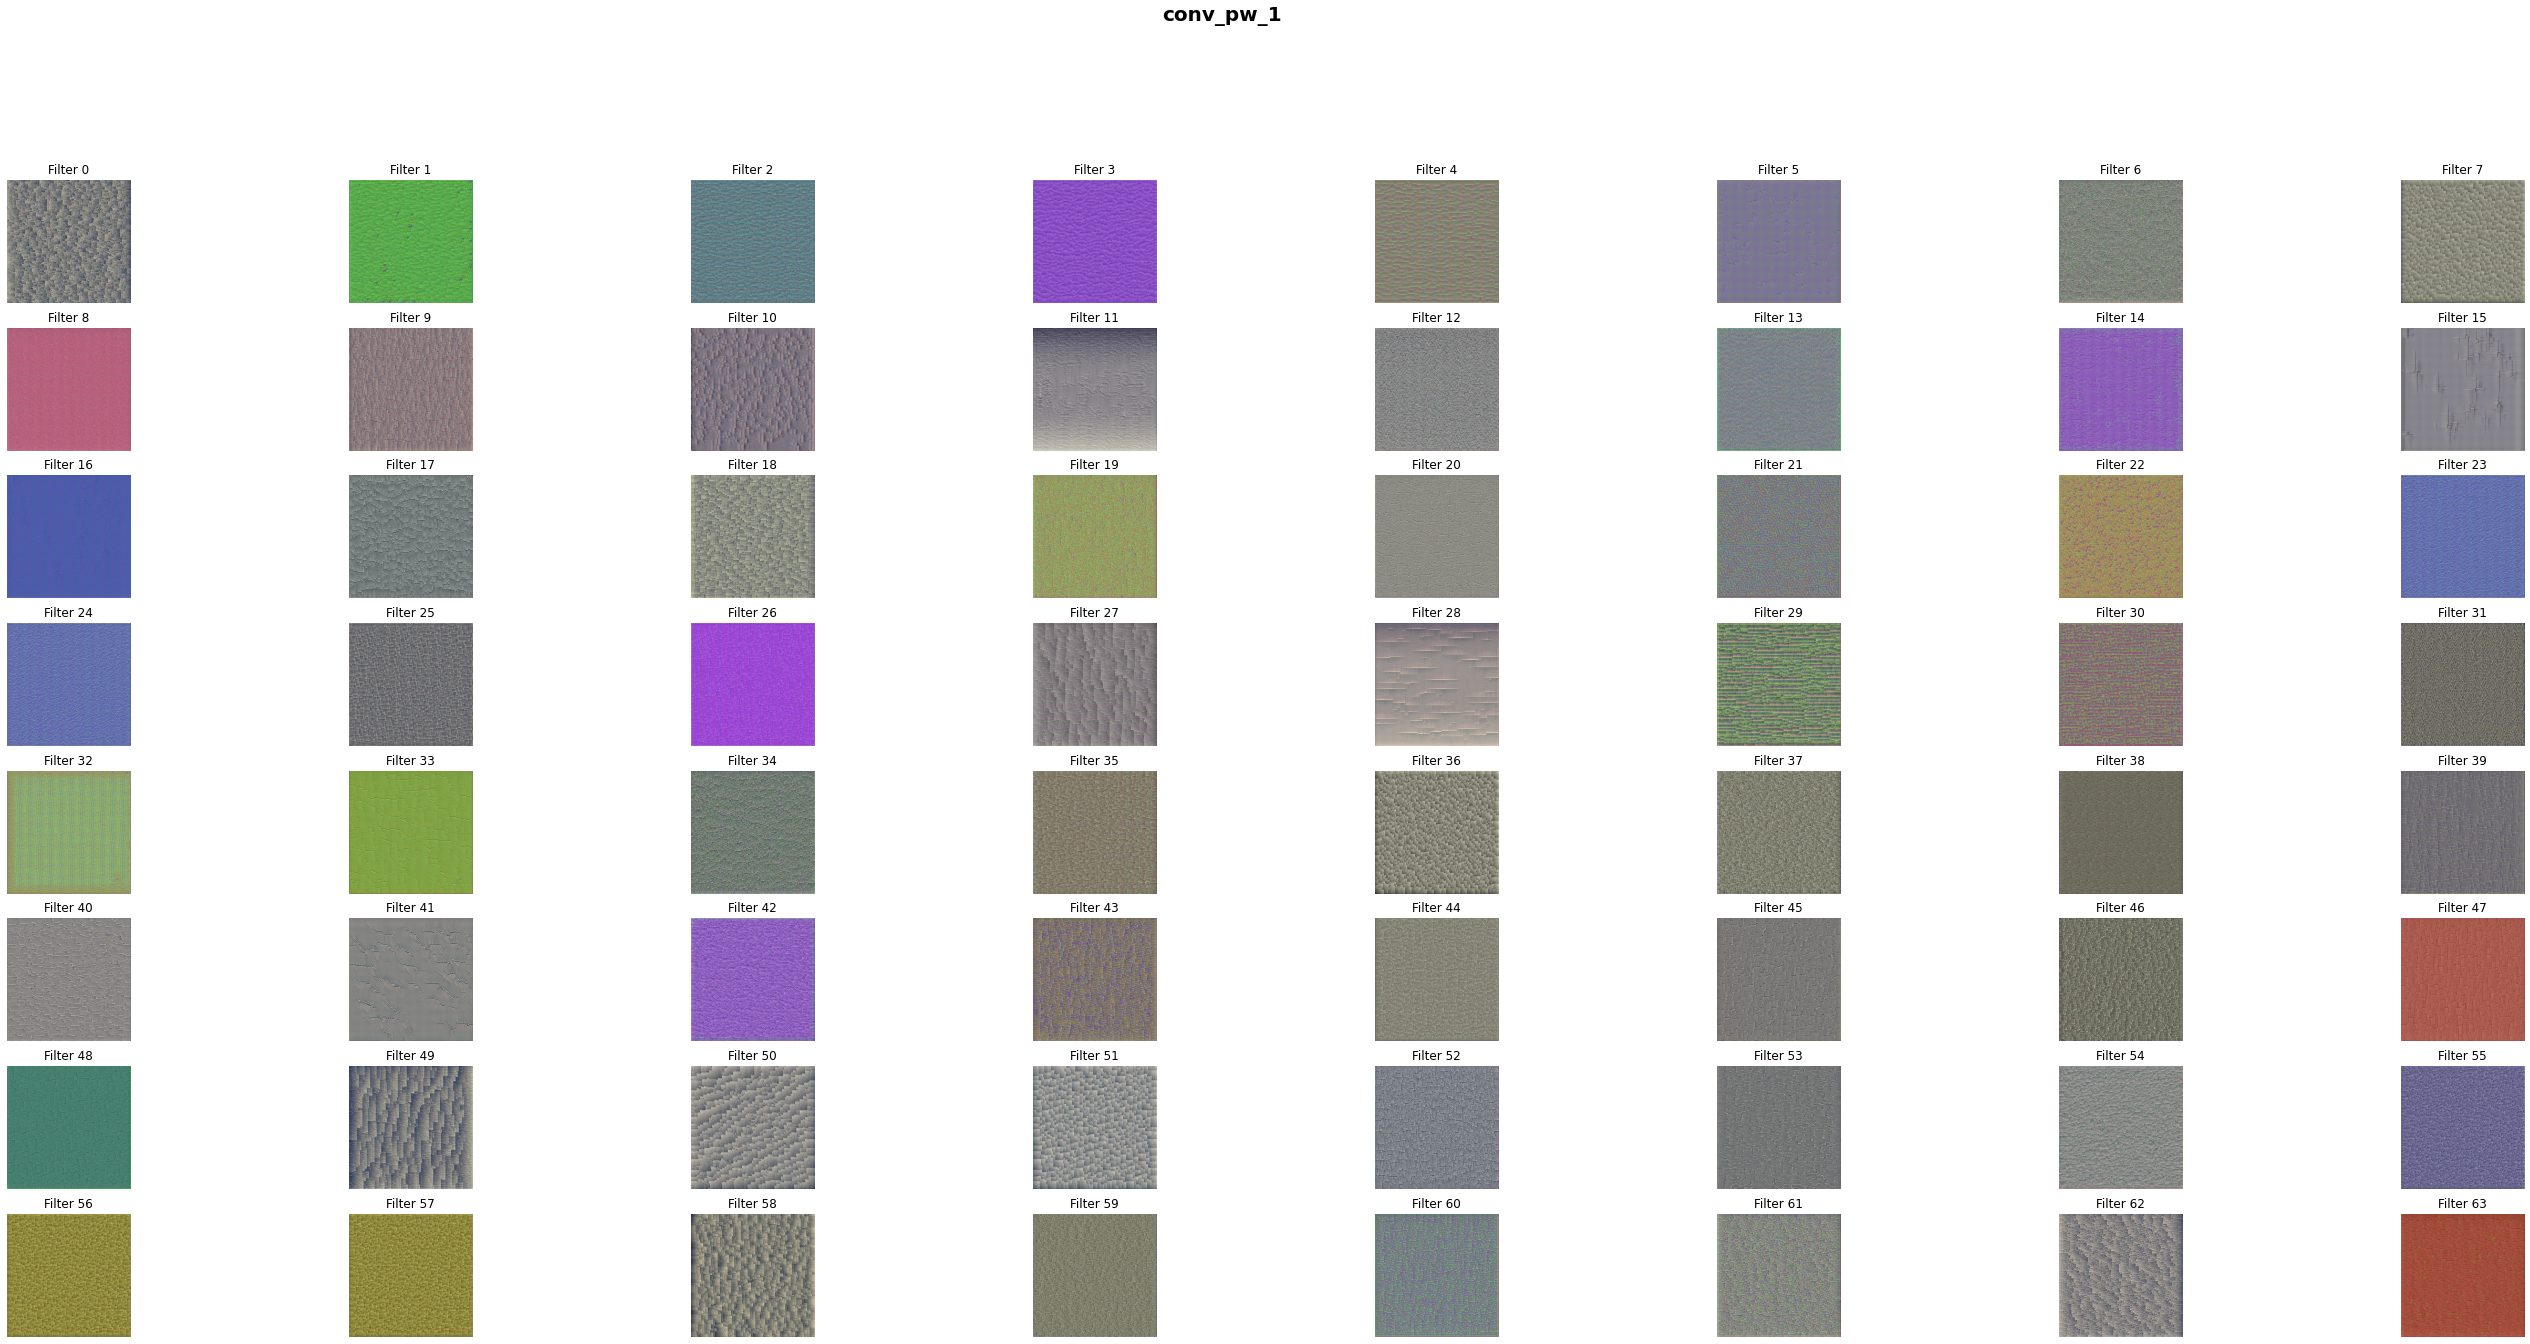

In [77]:
layer_name = 'conv_pw_1' #@param ['conv1', 'conv1_bn', 'conv1_relu', 'conv_dw_1', 'conv_dw_1_bn', 'conv_dw_1_relu', 'conv_pw_1', 'conv_pw_1_bn', 'conv_pw_1_relu', 'conv_pad_2', 'conv_dw_2', 'conv_dw_2_bn', 'conv_dw_2_relu', 'conv_pw_2', 'conv_pw_2_bn', 'conv_pw_2_relu', 'conv_dw_3', 'conv_dw_3_bn', 'conv_dw_3_relu', 'conv_pw_3', 'conv_pw_3_bn', 'conv_pw_3_relu', 'conv_pad_4', 'conv_dw_4', 'conv_dw_4_bn', 'conv_dw_4_relu', 'conv_pw_4', 'conv_pw_4_bn', 'conv_pw_4_relu', 'conv_dw_5', 'conv_dw_5_bn', 'conv_dw_5_relu', 'conv_pw_5', 'conv_pw_5_bn', 'conv_pw_5_relu', 'conv_pad_6', 'conv_dw_6', 'conv_dw_6_bn', 'conv_dw_6_relu', 'conv_pw_6', 'conv_pw_6_bn', 'conv_pw_6_relu', 'conv_dw_7', 'conv_dw_7_bn', 'conv_dw_7_relu', 'conv_pw_7', 'conv_pw_7_bn', 'conv_pw_7_relu', 'conv_dw_8', 'conv_dw_8_bn', 'conv_dw_8_relu', 'conv_pw_8', 'conv_pw_8_bn', 'conv_pw_8_relu', 'conv_dw_9', 'conv_dw_9_bn', 'conv_dw_9_relu', 'conv_pw_9', 'conv_pw_9_bn', 'conv_pw_9_relu', 'conv_dw_10', 'conv_dw_10_bn', 'conv_dw_10_relu', 'conv_pw_10', 'conv_pw_10_bn', 'conv_pw_10_relu', 'conv_dw_11', 'conv_dw_11_bn', 'conv_dw_11_relu', 'conv_pw_11', 'conv_pw_11_bn', 'conv_pw_11_relu', 'conv_pad_12', 'conv_dw_12', 'conv_dw_12_bn', 'conv_dw_12_relu', 'conv_pw_12', 'conv_pw_12_bn', 'conv_pw_12_relu', 'conv_dw_13', 'conv_dw_13_bn', 'conv_dw_13_relu', 'conv_pw_13', 'conv_pw_13_bn', 'conv_pw_13_relu']

visualize_all_filters(layer_name, iters=200)

Number of Filters: 128
Filter 0, Loss:  4.0698
Filter 1, Loss:  6.5778
Filter 2, Loss:  2.5897
Filter 3, Loss:  5.8137
Filter 4, Loss:  0.4550
Filter 5, Loss:  2.9775
Filter 6, Loss:  2.9650
Filter 7, Loss:  7.2930
Filter 8, Loss:  3.3692
Filter 9, Loss:  5.9911
Filter 10, Loss:  7.6656
Filter 11, Loss:  4.0140
Filter 12, Loss:  2.2316
Filter 13, Loss:  2.4259
Filter 14, Loss:  6.2477
Filter 15, Loss:  2.1258
Filter 16, Loss:  5.0775
Filter 17, Loss:  9.9473
Filter 18, Loss:  4.6955
Filter 19, Loss:  8.5796
Filter 20, Loss:  3.9761
Filter 21, Loss:  2.4564
Filter 22, Loss: -0.0000
Filter 23, Loss:  6.8636
Filter 24, Loss:  1.2859
Filter 25, Loss:  8.7188
Filter 26, Loss:  2.0728
Filter 27, Loss:  9.6696
Filter 28, Loss:  8.7493
Filter 29, Loss:  8.2507
Filter 30, Loss:  9.0726
Filter 31, Loss:  4.4390
Filter 32, Loss:  6.6140
Filter 33, Loss:  6.2140
Filter 34, Loss:  2.3106
Filter 35, Loss:  4.4683
Filter 36, Loss:  3.8765
Filter 37, Loss:  2.8013
Filter 38, Loss:  3.6938
Filter 39, L

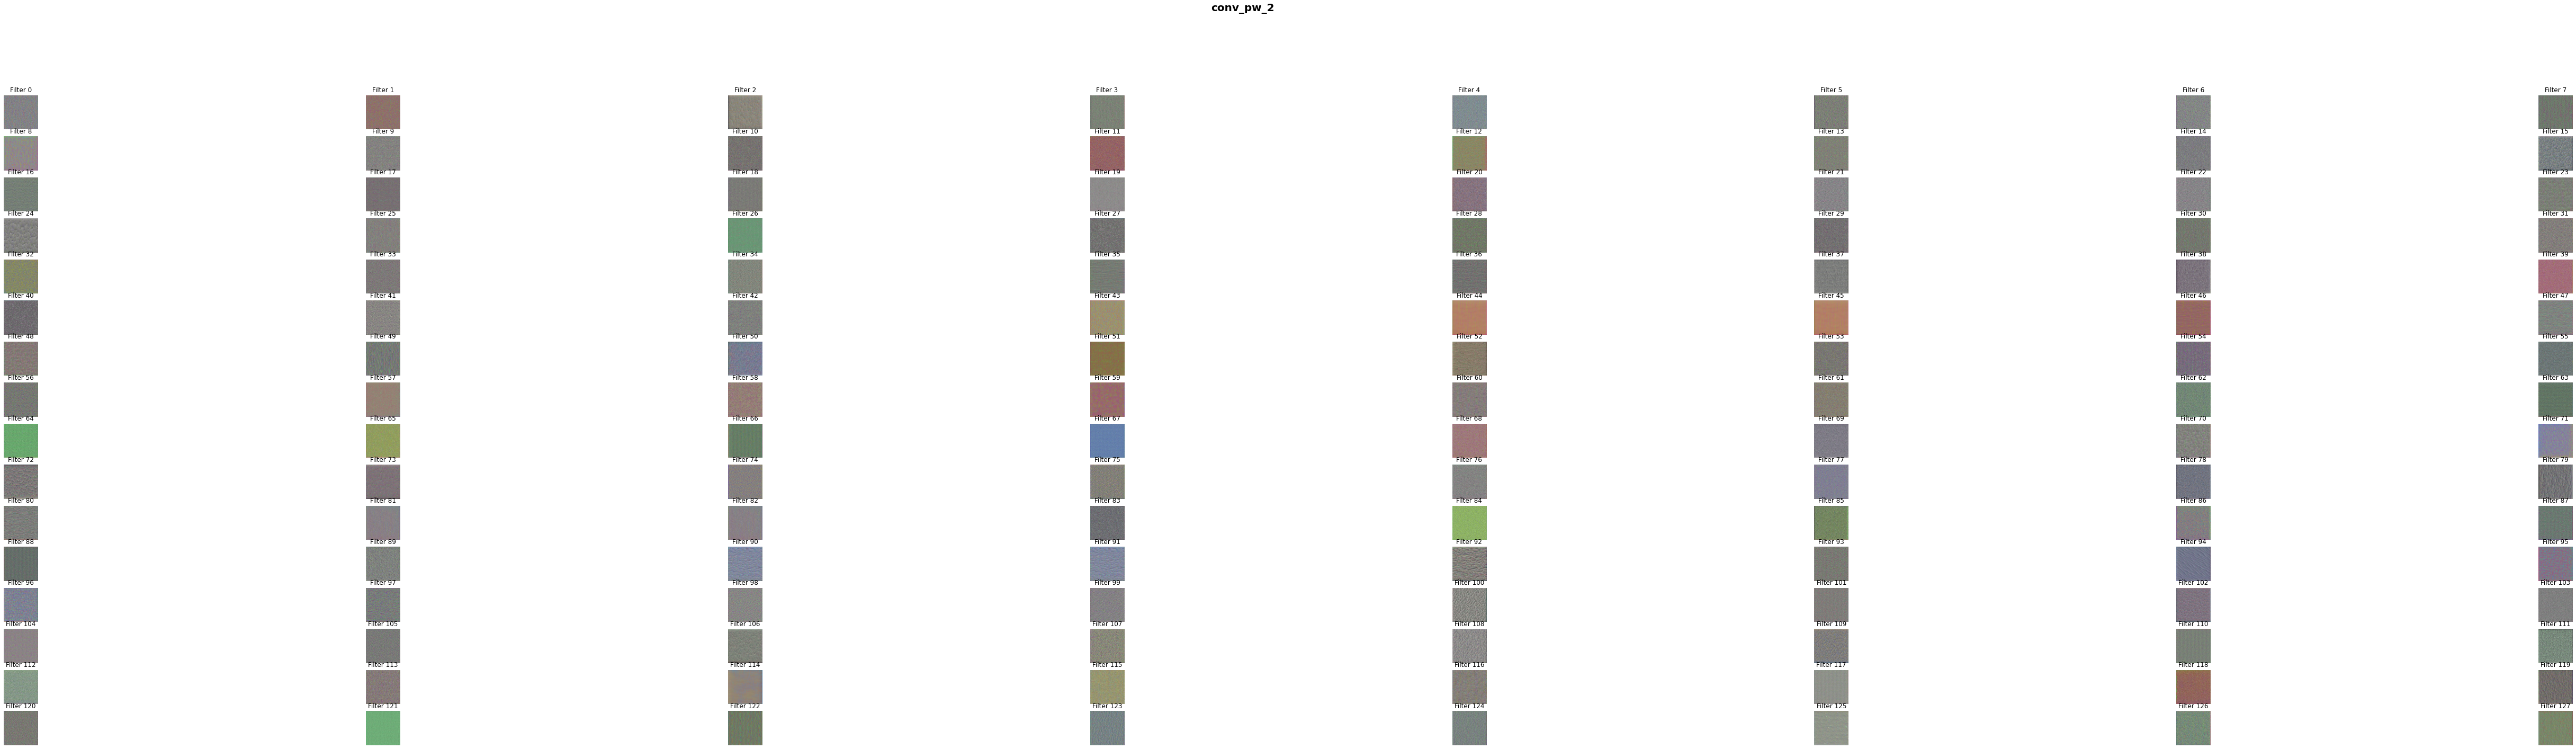

In [78]:
layer_name = 'conv_pw_2' #@param ['conv1', 'conv1_bn', 'conv1_relu', 'conv_dw_1', 'conv_dw_1_bn', 'conv_dw_1_relu', 'conv_pw_1', 'conv_pw_1_bn', 'conv_pw_1_relu', 'conv_pad_2', 'conv_dw_2', 'conv_dw_2_bn', 'conv_dw_2_relu', 'conv_pw_2', 'conv_pw_2_bn', 'conv_pw_2_relu', 'conv_dw_3', 'conv_dw_3_bn', 'conv_dw_3_relu', 'conv_pw_3', 'conv_pw_3_bn', 'conv_pw_3_relu', 'conv_pad_4', 'conv_dw_4', 'conv_dw_4_bn', 'conv_dw_4_relu', 'conv_pw_4', 'conv_pw_4_bn', 'conv_pw_4_relu', 'conv_dw_5', 'conv_dw_5_bn', 'conv_dw_5_relu', 'conv_pw_5', 'conv_pw_5_bn', 'conv_pw_5_relu', 'conv_pad_6', 'conv_dw_6', 'conv_dw_6_bn', 'conv_dw_6_relu', 'conv_pw_6', 'conv_pw_6_bn', 'conv_pw_6_relu', 'conv_dw_7', 'conv_dw_7_bn', 'conv_dw_7_relu', 'conv_pw_7', 'conv_pw_7_bn', 'conv_pw_7_relu', 'conv_dw_8', 'conv_dw_8_bn', 'conv_dw_8_relu', 'conv_pw_8', 'conv_pw_8_bn', 'conv_pw_8_relu', 'conv_dw_9', 'conv_dw_9_bn', 'conv_dw_9_relu', 'conv_pw_9', 'conv_pw_9_bn', 'conv_pw_9_relu', 'conv_dw_10', 'conv_dw_10_bn', 'conv_dw_10_relu', 'conv_pw_10', 'conv_pw_10_bn', 'conv_pw_10_relu', 'conv_dw_11', 'conv_dw_11_bn', 'conv_dw_11_relu', 'conv_pw_11', 'conv_pw_11_bn', 'conv_pw_11_relu', 'conv_pad_12', 'conv_dw_12', 'conv_dw_12_bn', 'conv_dw_12_relu', 'conv_pw_12', 'conv_pw_12_bn', 'conv_pw_12_relu', 'conv_dw_13', 'conv_dw_13_bn', 'conv_dw_13_relu', 'conv_pw_13', 'conv_pw_13_bn', 'conv_pw_13_relu']

visualize_all_filters(layer_name, iters=200)

Iteration: 20, Loss:  5.0416
Iteration: 40, Loss:  5.8946
Iteration: 60, Loss:  6.3623
Iteration: 80, Loss:  6.6458
Iteration: 100, Loss:  6.9324
Iteration: 120, Loss:  7.0843
Iteration: 140, Loss:  7.3090
Iteration: 160, Loss:  7.4470
Iteration: 180, Loss:  7.5390
Iteration: 200, Loss:  7.6146


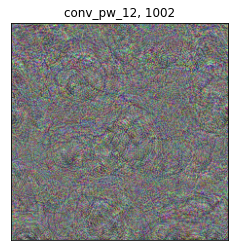

In [91]:
layer_name = 'conv_pw_12' #@param ['conv1', 'conv1_bn', 'conv1_relu', 'conv_dw_1', 'conv_dw_1_bn', 'conv_dw_1_relu', 'conv_pw_1', 'conv_pw_1_bn', 'conv_pw_1_relu', 'conv_pad_2', 'conv_dw_2', 'conv_dw_2_bn', 'conv_dw_2_relu', 'conv_pw_2', 'conv_pw_2_bn', 'conv_pw_2_relu', 'conv_dw_3', 'conv_dw_3_bn', 'conv_dw_3_relu', 'conv_pw_3', 'conv_pw_3_bn', 'conv_pw_3_relu', 'conv_pad_4', 'conv_dw_4', 'conv_dw_4_bn', 'conv_dw_4_relu', 'conv_pw_4', 'conv_pw_4_bn', 'conv_pw_4_relu', 'conv_dw_5', 'conv_dw_5_bn', 'conv_dw_5_relu', 'conv_pw_5', 'conv_pw_5_bn', 'conv_pw_5_relu', 'conv_pad_6', 'conv_dw_6', 'conv_dw_6_bn', 'conv_dw_6_relu', 'conv_pw_6', 'conv_pw_6_bn', 'conv_pw_6_relu', 'conv_dw_7', 'conv_dw_7_bn', 'conv_dw_7_relu', 'conv_pw_7', 'conv_pw_7_bn', 'conv_pw_7_relu', 'conv_dw_8', 'conv_dw_8_bn', 'conv_dw_8_relu', 'conv_pw_8', 'conv_pw_8_bn', 'conv_pw_8_relu', 'conv_dw_9', 'conv_dw_9_bn', 'conv_dw_9_relu', 'conv_pw_9', 'conv_pw_9_bn', 'conv_pw_9_relu', 'conv_dw_10', 'conv_dw_10_bn', 'conv_dw_10_relu', 'conv_pw_10', 'conv_pw_10_bn', 'conv_pw_10_relu', 'conv_dw_11', 'conv_dw_11_bn', 'conv_dw_11_relu', 'conv_pw_11', 'conv_pw_11_bn', 'conv_pw_11_relu', 'conv_pad_12', 'conv_dw_12', 'conv_dw_12_bn', 'conv_dw_12_relu', 'conv_pw_12', 'conv_pw_12_bn', 'conv_pw_12_relu', 'conv_dw_13', 'conv_dw_13_bn', 'conv_dw_13_relu', 'conv_pw_13', 'conv_pw_13_bn', 'conv_pw_13_relu']

visualize_filter(layer_name, iters=200)